# <h1><center> Predictive Analysis - Web Traffic Time Series Forecasting | Kaggle

The goal of this notebook is not to do the best model for each Time series. It is just a comparison of few models when you have one Time Series. The presentation present a different approaches to forecast a Time Series. 

The plan of the notebook is:

    I. Importation & Data Cleaning
    II. Aggregation & Visualisation
    III. Machine Learning Approach
    IV Basic Model Approach
    V. ARIMA approach (Autoregressive Integrated Moving Average)
    VI. (FB) Prophet Approach 
    VII. Keras Starter
    VIII. Comparaison & Conclusion


#  <h1><center> I. Importation & Data Cleaning

In this first part we will choose the Time Series to work in the others parts. The idea is to find a Time Serie who could be interesting to work with. So in the data we can find 145K Time Series. We will Find a good Time Series to introduce four approaches! So the first step is to import few libraries and the data. The four approaches are Basic Approach / ML Approach / GAM Approach / ARIMA Approach.

In [33]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [34]:
# Load the data
train = pd.read_csv("./input/train_1.csv")

In [35]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)


In [36]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [37]:
train_flattened.reset_index(drop=False,inplace=True)

In [38]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

In [39]:
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [40]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


This part allowed us to prepare our data. We had created new features that we use in the next steps. Days, Months, Years are interesting to forecast with a Machine Learning Approach or to do an analysis. 
If you have another idea to improve this first part: Fork this notebook and improve it or share your idea in the comments.

# <h1><center>II. Aggregation & Visualisation

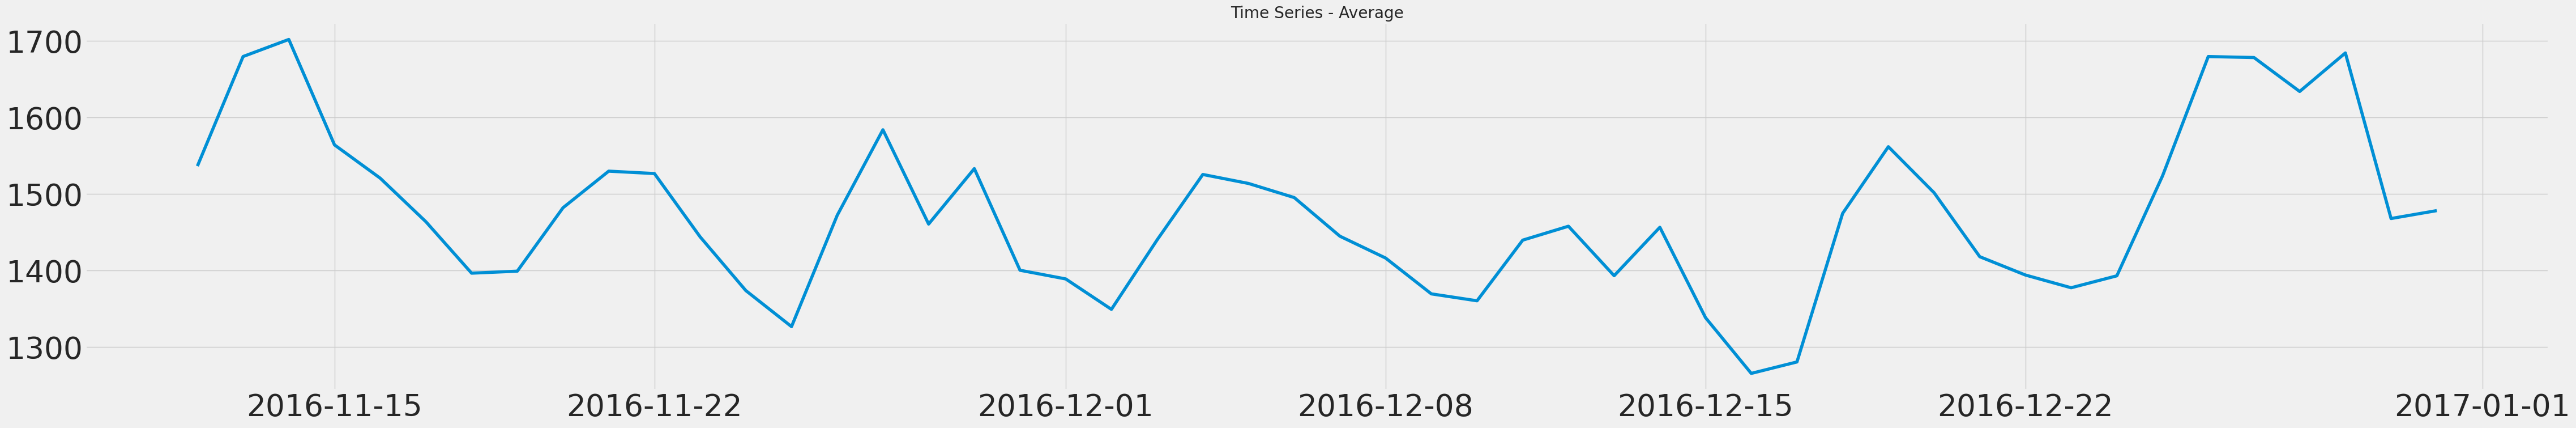

In [41]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

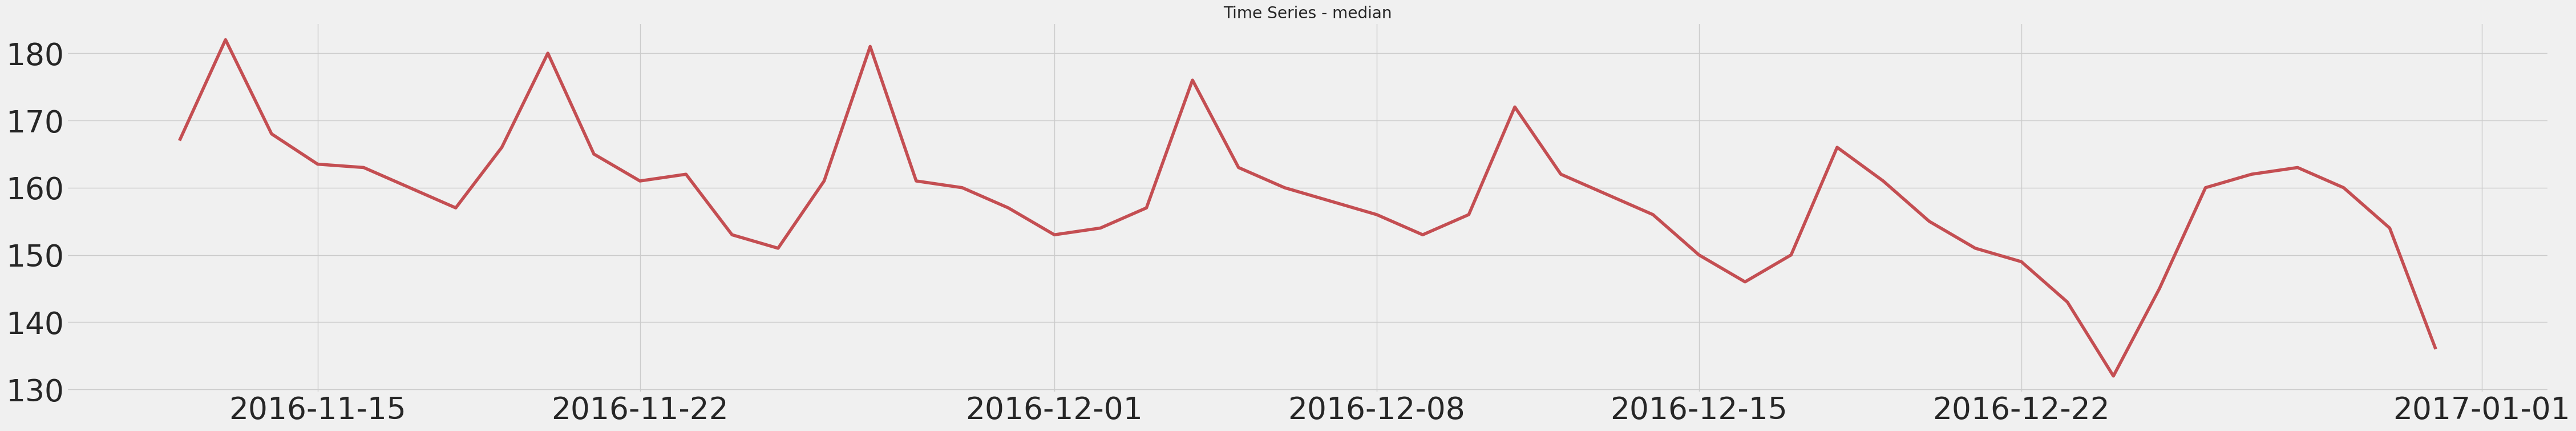

In [42]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

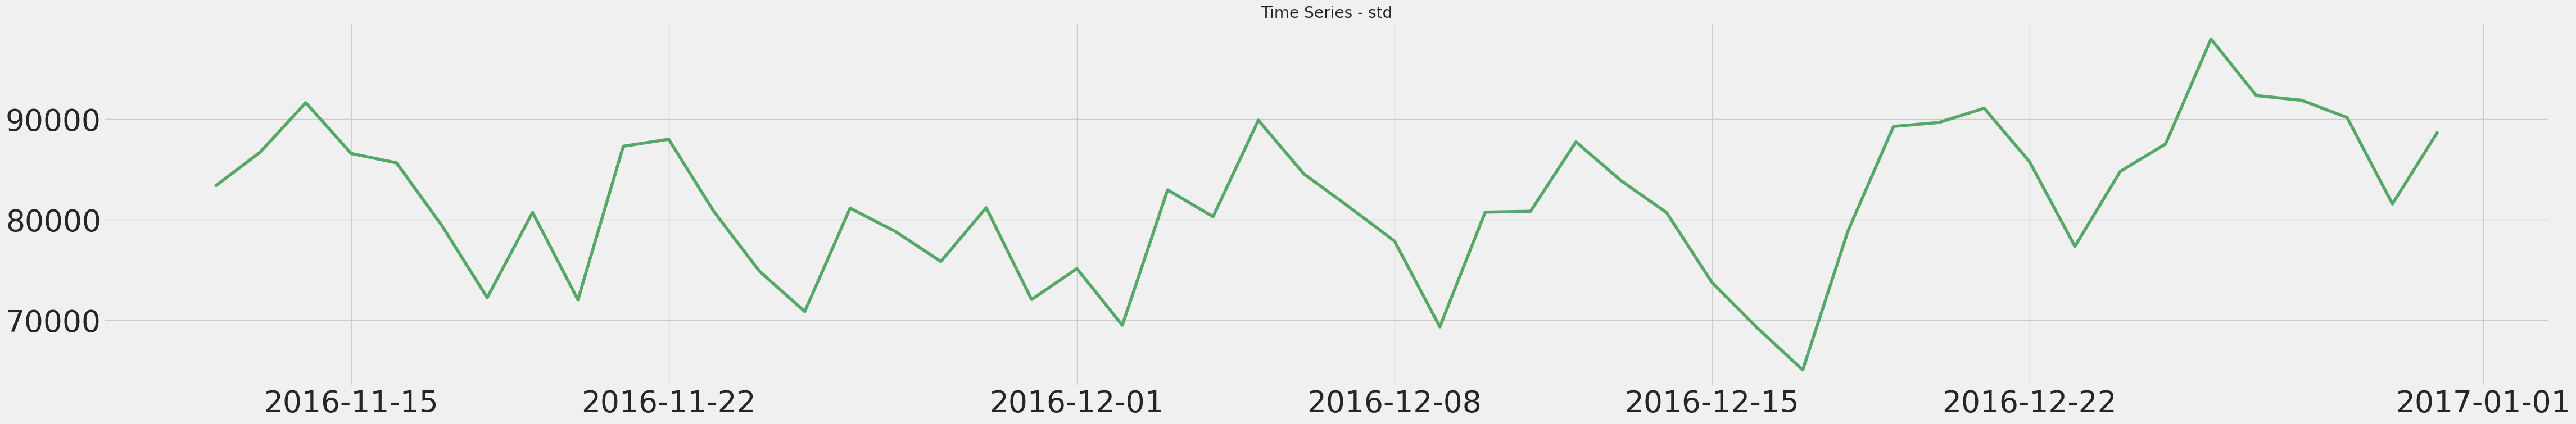

In [43]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [44]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [45]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot(index='weekday',columns='month',values='Visits')
train_group.sort_index(inplace=True)

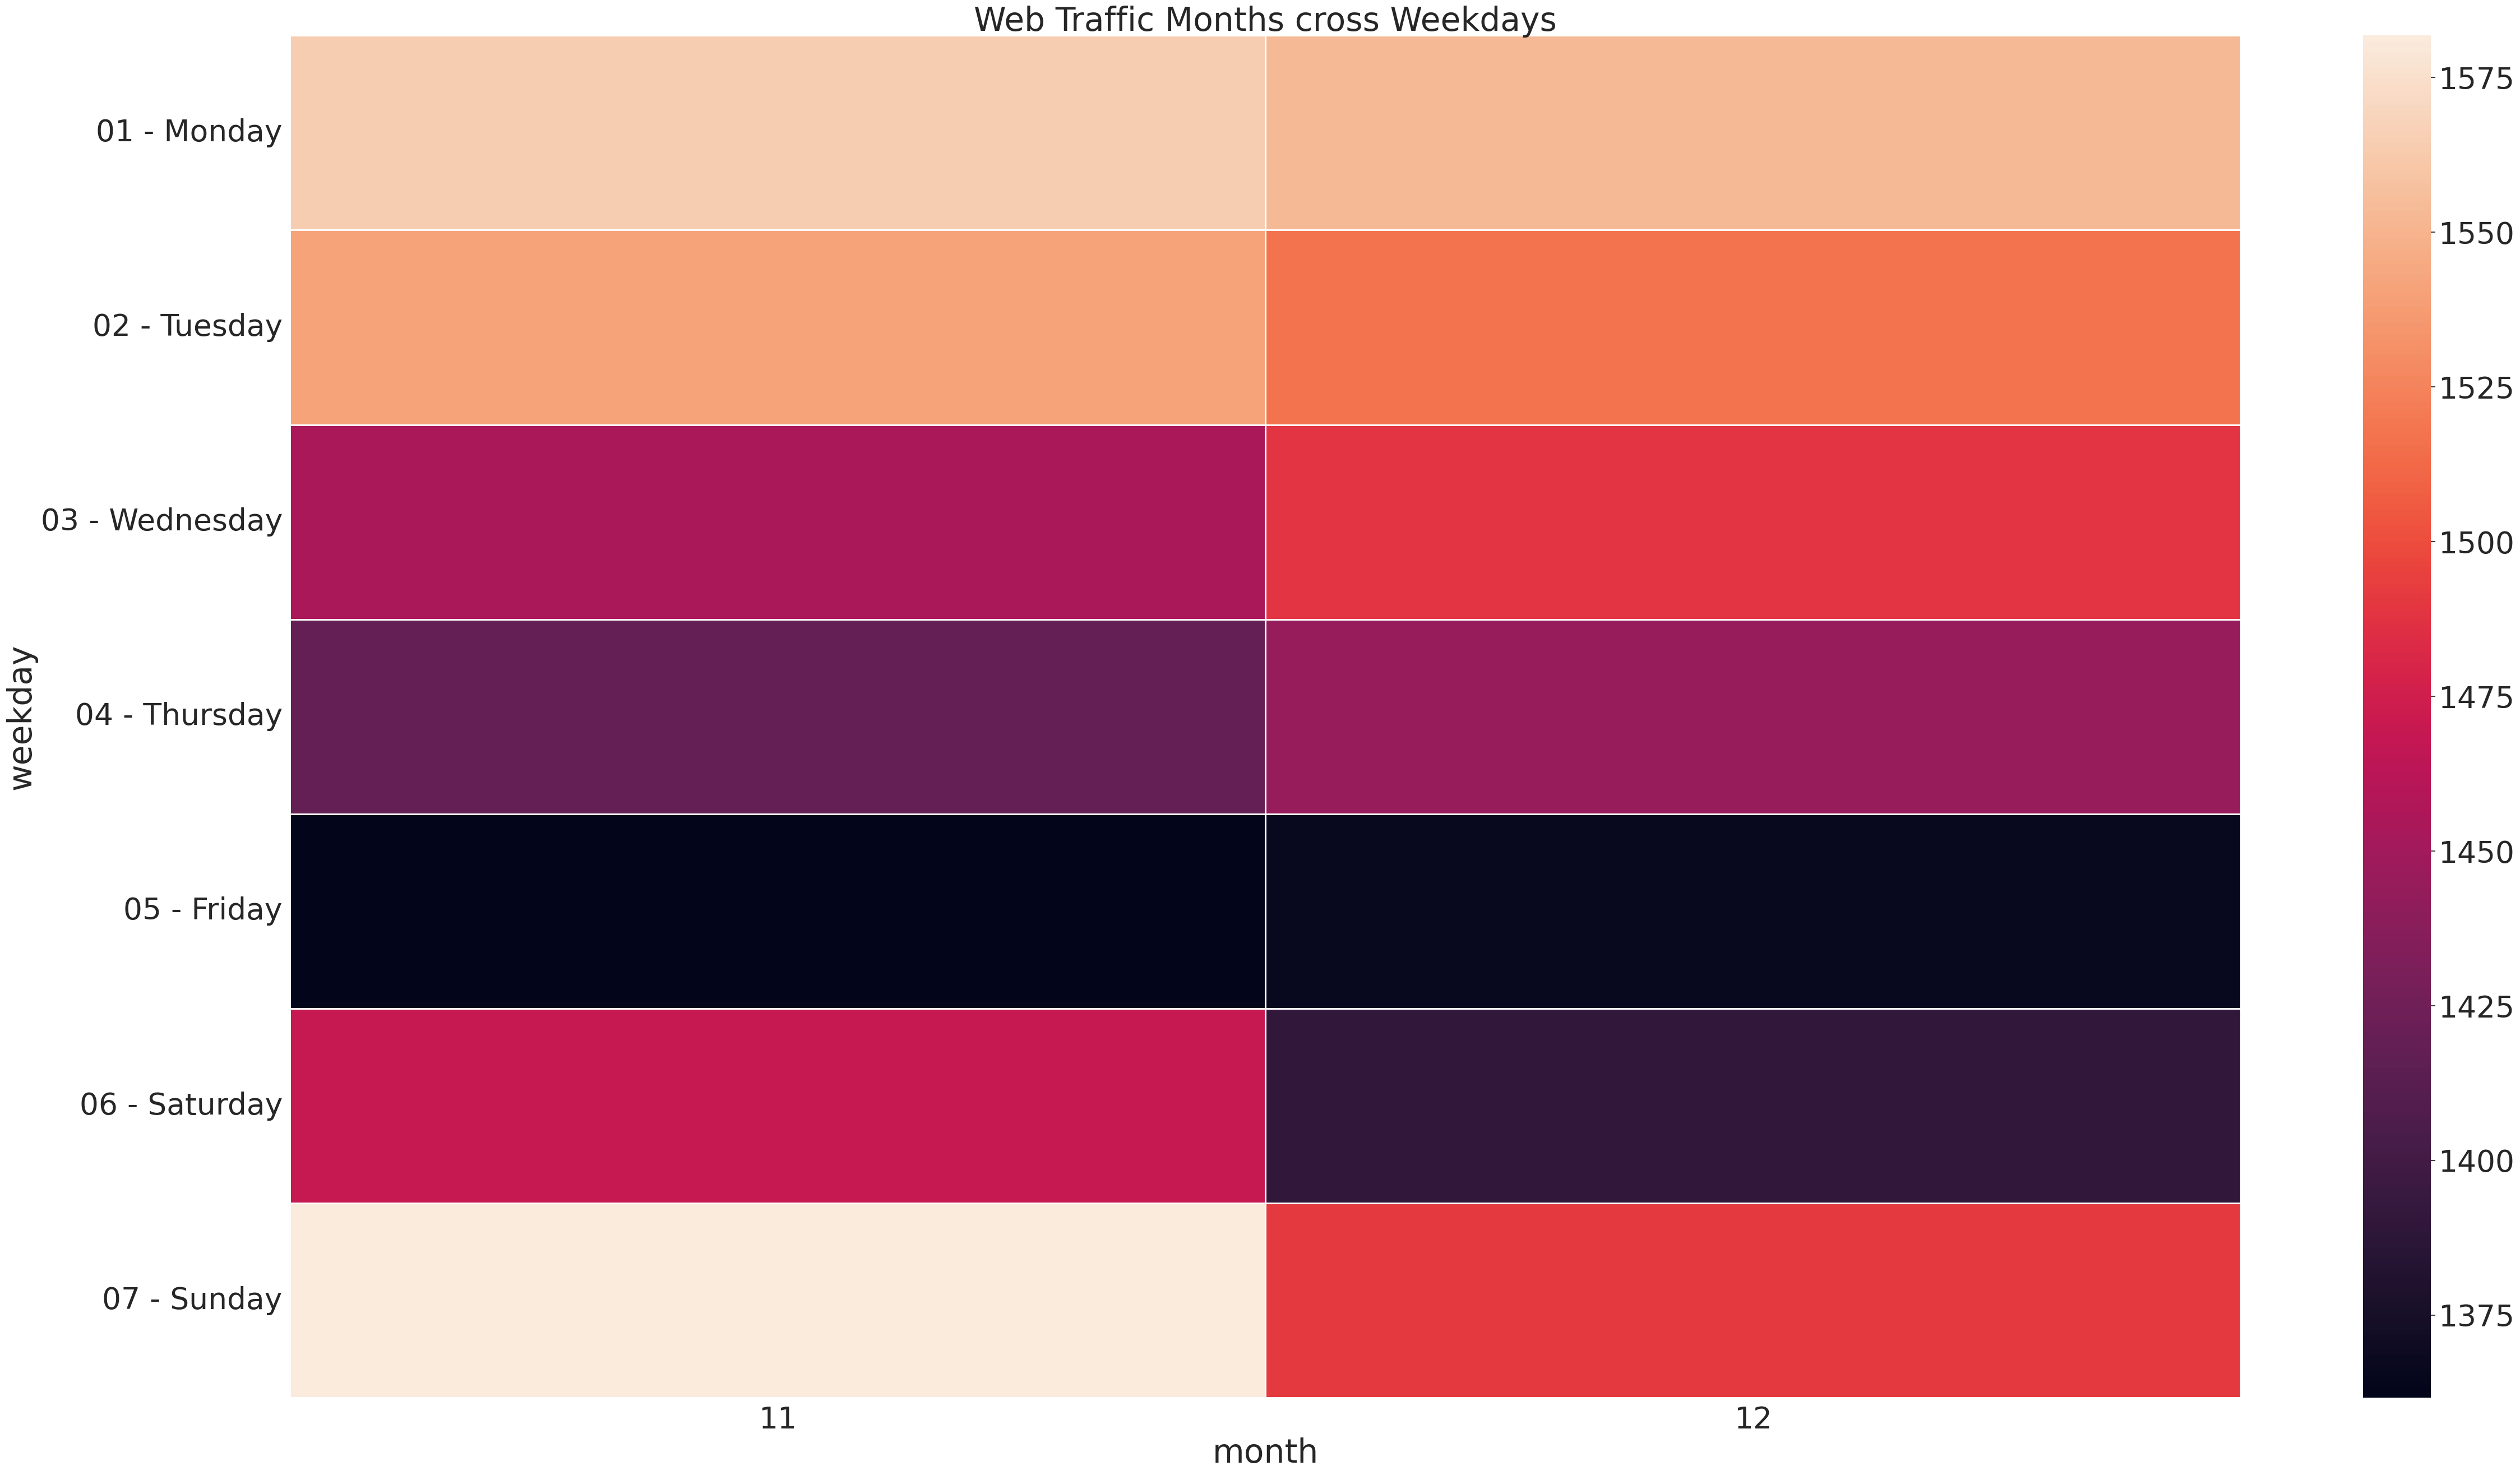

In [46]:
sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

This heatmap show us in average the web traffic by weekdays cross the months. In our data we can see there are less activity in Friday and Saturday for December and November. And the biggest traffic is on the period Monday - Wednesday. It is possible to do Statistics Test to check if our intuition is ok. But You have a lot of works ! 

In [49]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot(index='day',columns='month',values='Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

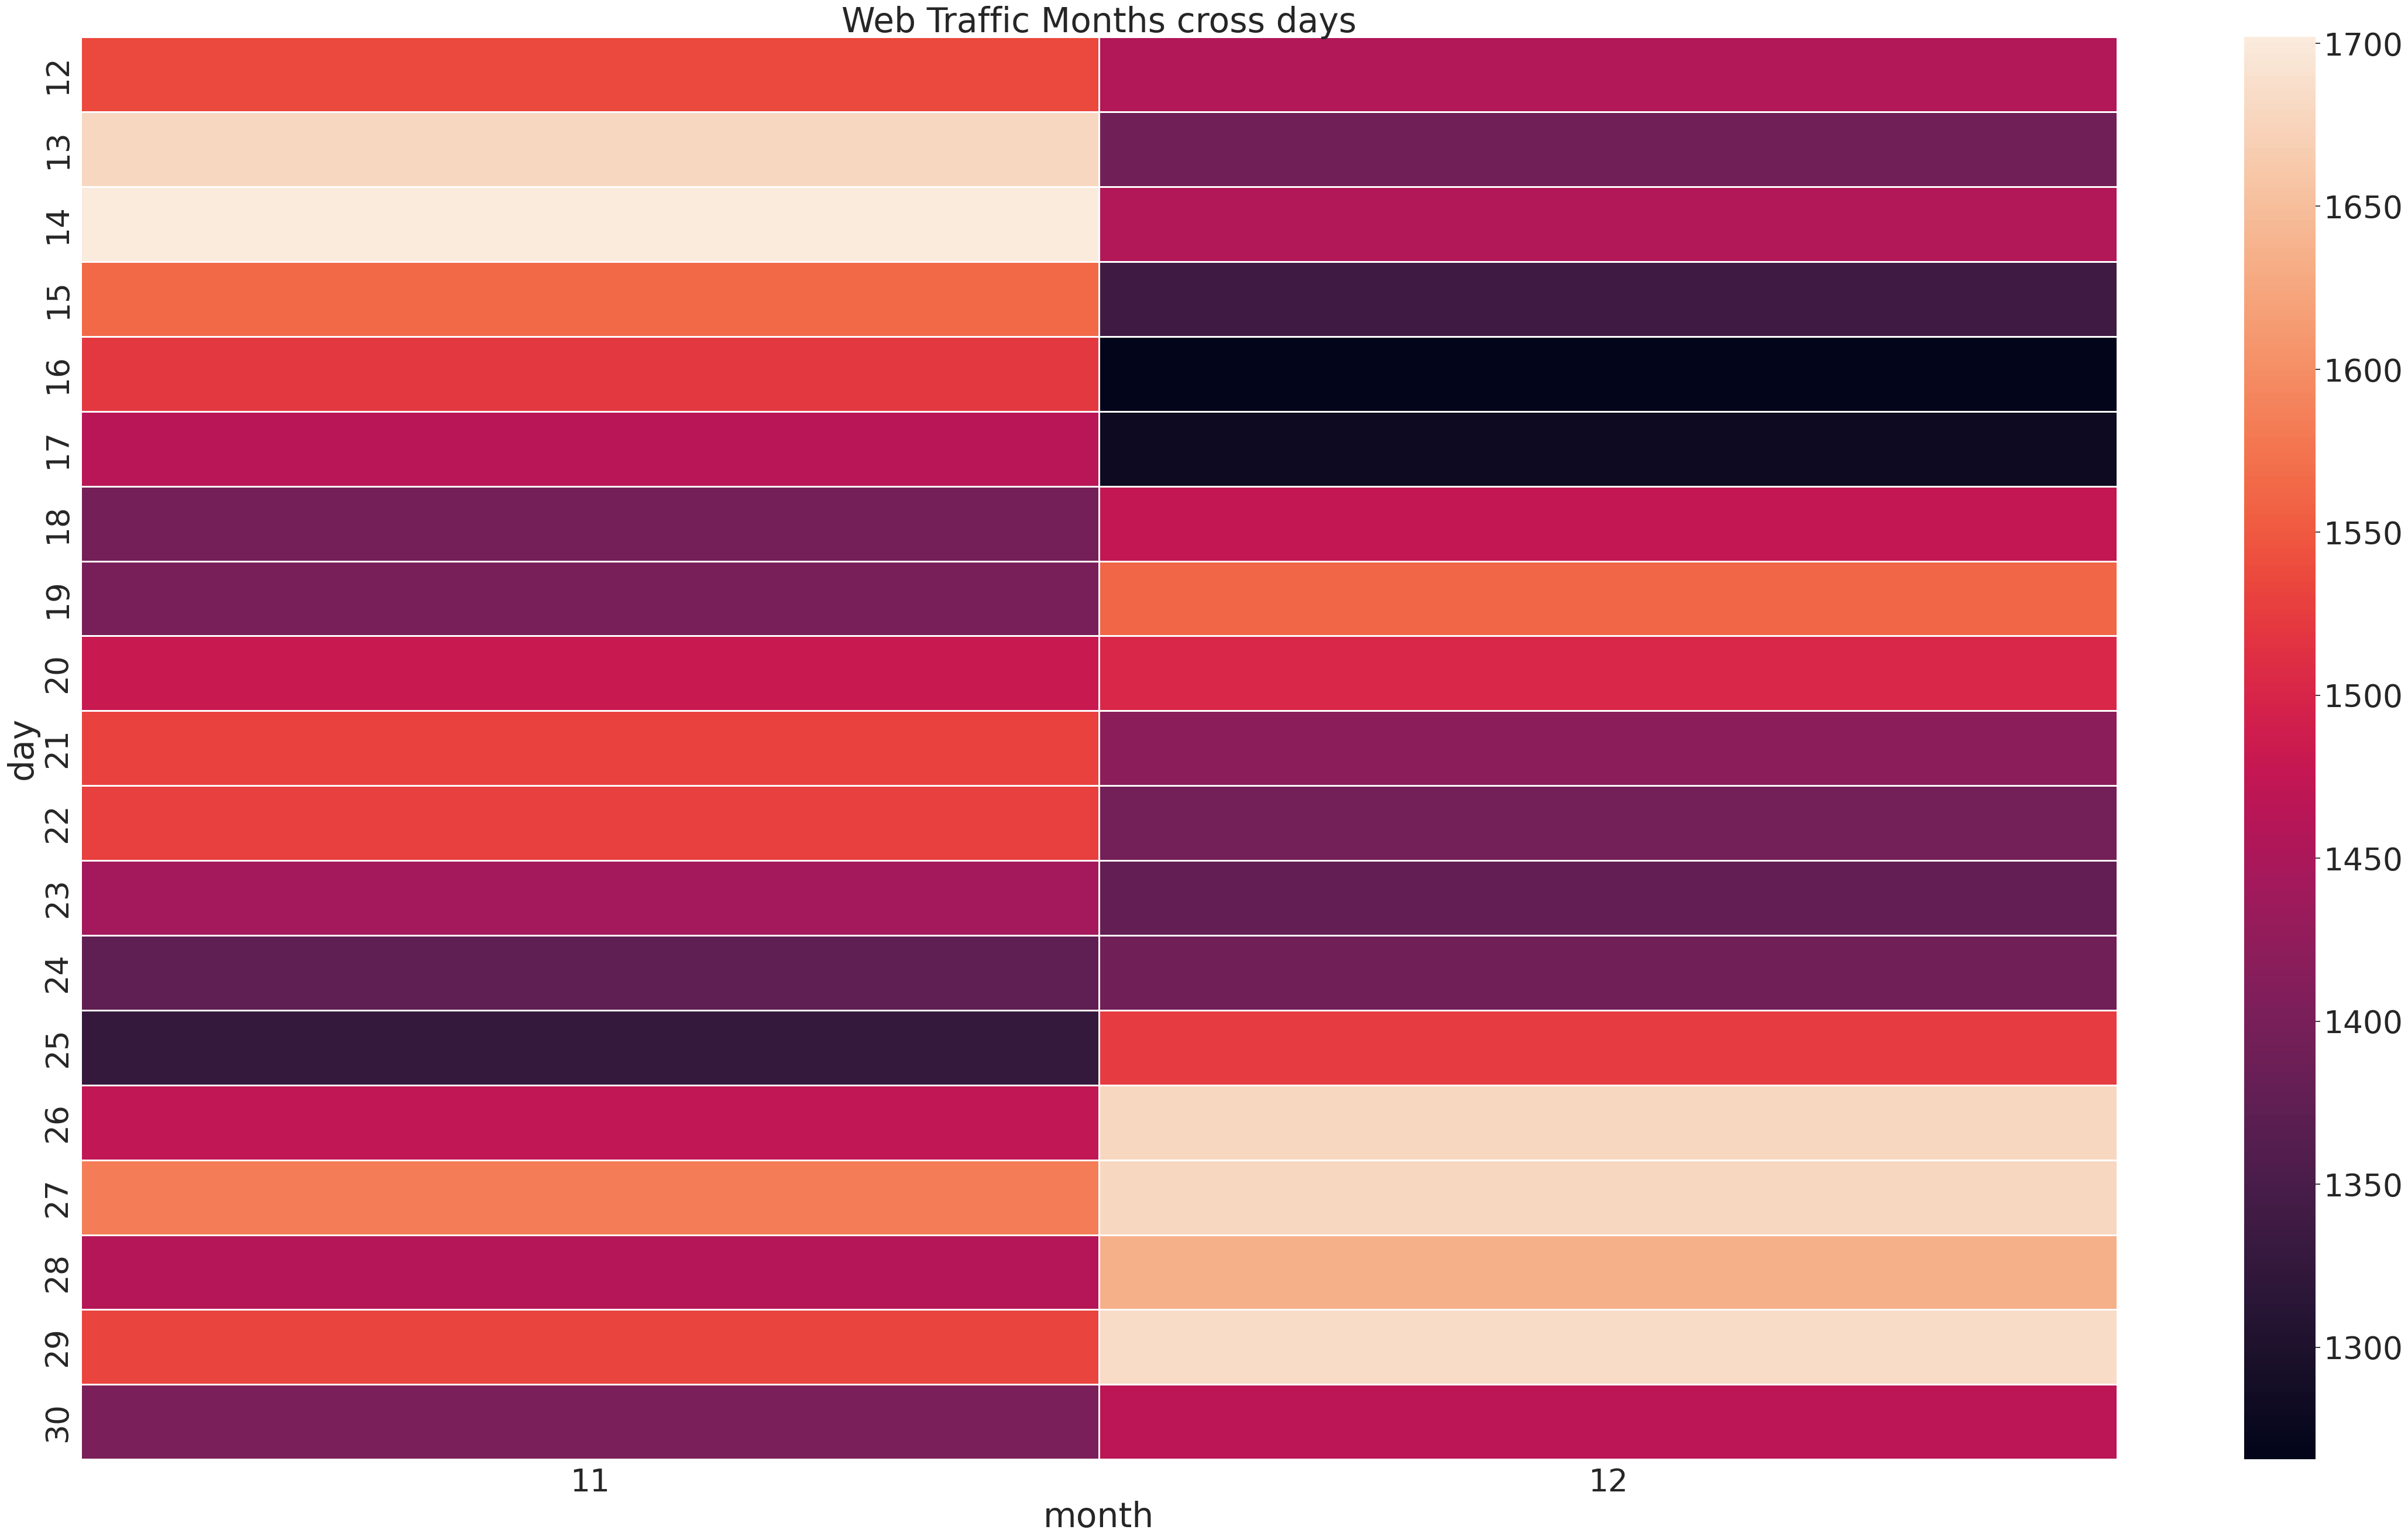

In [50]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

With this graph it is possible to see they are two periods with a bigger activity than the rest. The two periods are 25-29 December and 13-14 November. And we can see one period with little activity 15-17 December. They are maybe few outliers during these two periods. You must to investigate more. (coming soon...)

#  <h1><center> III. ML Approach


The first approach introduces is the Machine Learnin Approach. We will use just a AdaBoostRegressor but you can try with other models if you want to find the best model. I tried with a linear model as like Ridge but ADA model is better. I will be interesting to check if GB or XGB can bit ADA. It is possible to do a Neural Network approach too. But this approach will be done if the kagglers want more !!

In [56]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',n=2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',n=2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()


,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


The first step for the ML approach is to create the feature that we will predict. In our example we don't predict the number of visits but the difference between two days. The tips to create few features is to take the difference between two days and to do a lag. Here we will take a lag of "diff" seven times. If you have a weekly pattern it is an interesting choice. Here we have few data (2 months so 30 values) and it is a contraint. I done some test and the number 7 is a good choice (weekly pattern?).  

In [60]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.iloc[1:, data.columns.get_loc("diff")] = (data.iloc[1:, data.columns.get_loc("Visits")].to_numpy() - data.iloc[:len(data)-1, data.columns.get_loc("Visits")].to_numpy())
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()

In [61]:
lagged.head()

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1536.471757,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2016-11-13,1679.630589,6,2016,11,13,143.158833,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2016-11-14,1701.941831,0,2016,11,14,22.311241,143.158833,NaN,0.000000,0.0,0.0,0.0,0.0
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0,0.0
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0


In [62]:
# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

#  <h1><center>VI. Prophet

Prophet is a forecasting tool availaible in python and R. This tool was created by Facebook. More information on the library here: https://research.fb.com/prophet-forecasting-at-scale/

Compared to the two methods this one will be faster. We can forecast a time series with few lines. In our case we will do a forecast and a display the trend of activity on the period and for a week.


20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing


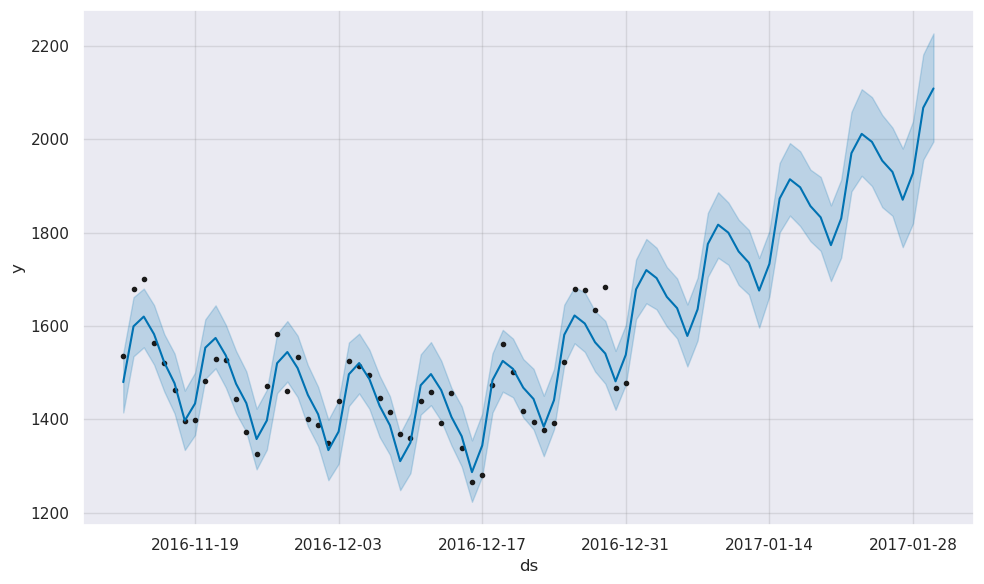

In [94]:
from prophet import Prophet
sns.set(font_scale=1) 
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

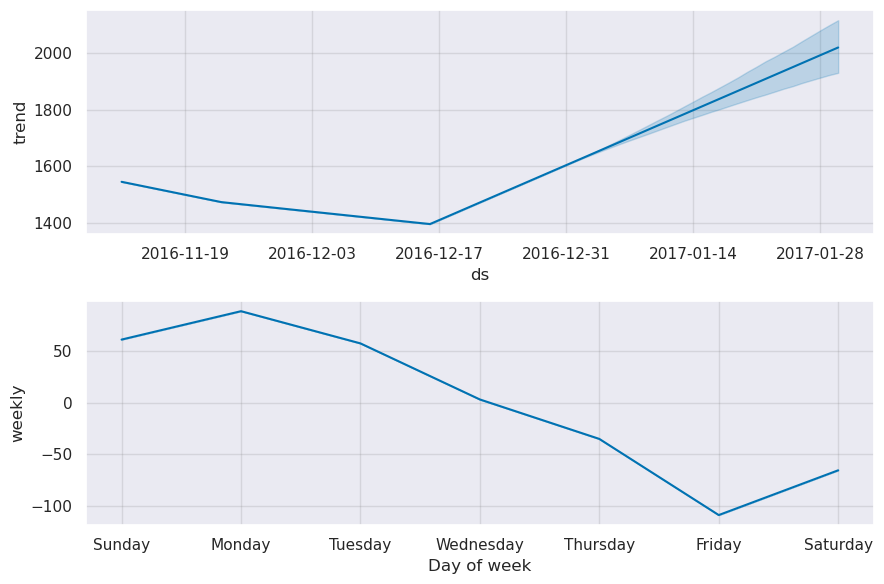

In [95]:
m.plot_components(forecast);

#  <h1><center>VI. Keras Starter

In this part we will use Keras without optimisation to forecast. It is just a very simple code to begin with Keras and a Time Series. For our example we will try just with one layer and 8 Neurons.

In [ ]:
df_dl = times_series_means[['date','Visits']]

train_size = int(len(df_dl) * 0.80)
test_size = len(df_dl) - train_size
train, test = df_dl.iloc[0:train_size,:], df_dl.iloc[train_size:len(df_dl),:]
print(len(train), len(test))

In [ ]:
look_back = 1

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1].values[0]
        b = dataset.iloc[i+look_back, 1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=2, verbose=0)

In [ ]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore, trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (testScore, testScore))

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_dl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_dl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_dl)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(np.array(df_dl.Visits))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Predicition with Keras')
plt.show()

 # <h1><center>VII. Comparison & Conclusion

In Progress...